# Getting started with InferLO

In this Notebook we will show how to define a Graphical Model using InferLO and how to solve difference tasks (inference, maximum likelihood and sampling) for that model. 

Also we will review basic concepts (variables, factors), different kinds of models (generic, pairwise and Normal Factor Graph), and show how you can use different algorithms to solve the same problem.

In [20]:
# Temporary hack.
import sys 
sys.path.append('../..')

In [21]:
import inferlo
import numpy as np
from matplotlib import pyplot as plt

## Conversion from factor graph to Forney-style edge-variable graph and back

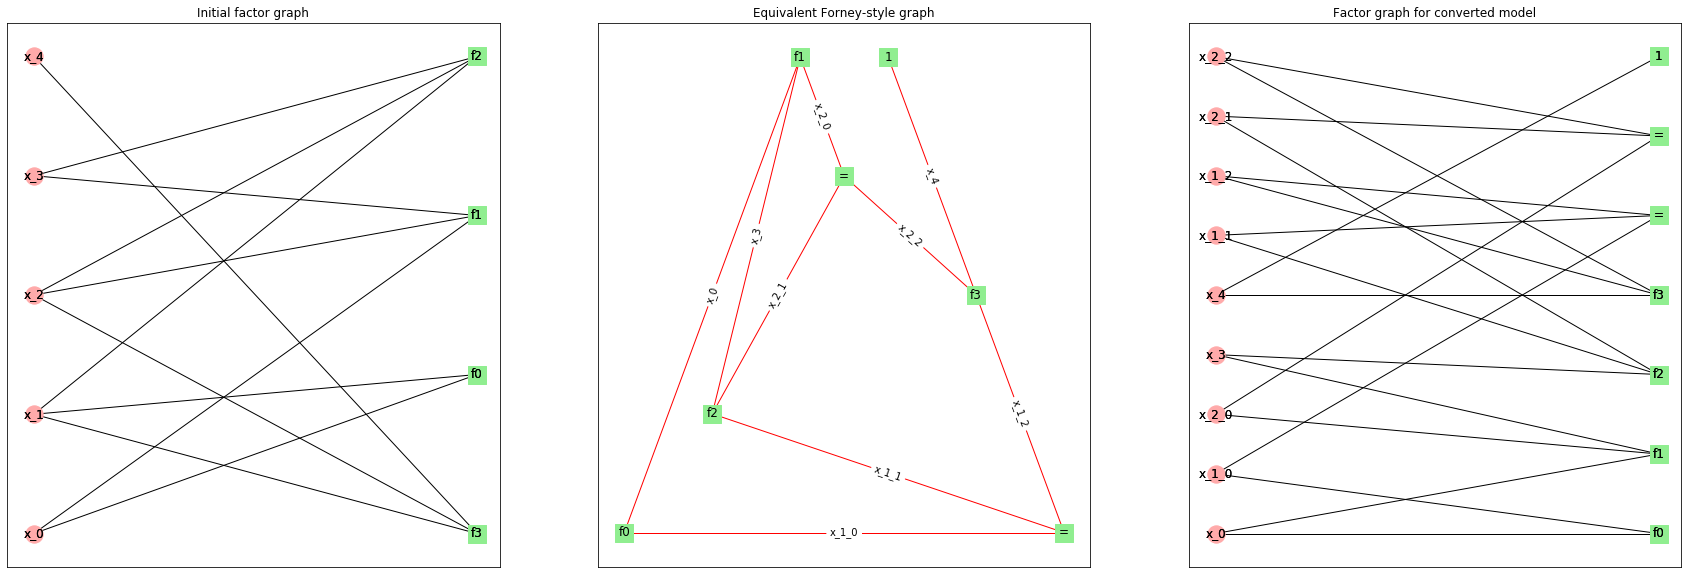

In [22]:
model1 = inferlo.GenericGraphModel(num_variables = 5)
x1, x2, x3, x4, x5 = inferlo.FunctionFactor.prepare_variables(model1)
model1 *= np.exp(x1*x2)
model1 *= np.exp(x1*x3*x4)
model1 *= np.exp(x2*x3*x4)
model1 *= np.exp(x2*x3*x5)

for i in range(len(model1.factors)):
    model1.factors[i].name = 'f%d' % i
    
fig = plt.figure(figsize=(30, 10))
model1.draw_factor_graph(fig.add_subplot(1, 3, 1)) 


model2 = inferlo.NormalFactorGraphModel.from_model(model1) 
model2.draw_edge_variable_graph(fig.add_subplot(1, 3, 2))
model2.draw_factor_graph(fig.add_subplot(1, 3, 3))

ax = fig.get_axes()
ax[0].set_title('Initial factor graph')
ax[1].set_title('Equivalent Forney-style graph')
ax[2].set_title('Factor graph for converted model')
plt.show()

## Conversion from pairwise to factor-graph and Forney-style

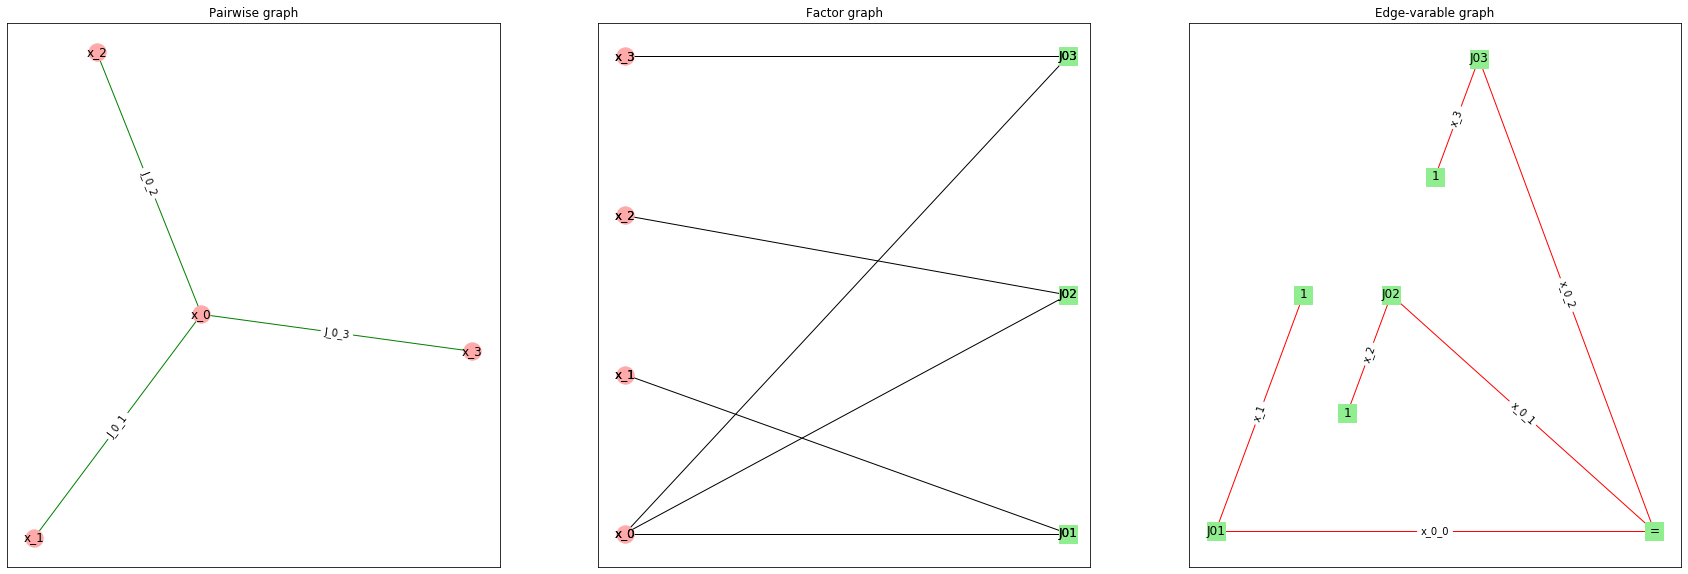

In [14]:
field = np.zeros((4, 2))
edges = [[0, 1], [0, 2], [0, 3]]
j1 = np.array([[0, 0], [0, 1]])
interactions = [j1, j1, j1]
model1 = inferlo.PairWiseFiniteModel.create(field, edges, interactions)

fig = plt.figure(figsize=(30, 10))
model1.draw_pairwise_graph(fig.add_subplot(1, 3, 1))

model1.draw_factor_graph(fig.add_subplot(1, 3, 2))

model2 = inferlo.NormalFactorGraphModel.from_model(model1) 
model2.draw_edge_variable_graph(fig.add_subplot(1, 3, 3))

ax = fig.get_axes()
ax[0].set_title('Pairwise graph')
ax[1].set_title('Factor graph')
ax[2].set_title('Edge-varable graph')
plt.show()

## Inference / optimization.

[2, 2, 2, 0, 0]

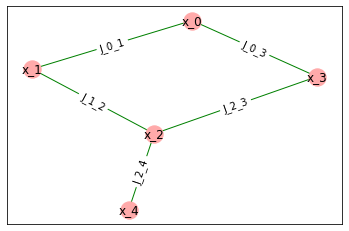

In [25]:
model = inferlo.PairWiseFiniteModel(5, 3)
x = inferlo.FunctionFactor.prepare_variables(model)
model *= np.exp(3*x[0]*x[1])
model *= np.exp(4*x[1]*x[2])
model *= np.exp(-2*x[2]*x[3])
model *= np.exp(-6*x[2]*x[4])
model *= np.exp(x[3]*x[0])
model.draw_pairwise_graph(plt)

# Also can explictly set interactions as 3x3 matrices.

model.infer(algorithm='message_passing')
model.max_likelihood()

In [26]:
from pypandoc.pandoc_download import download_pandoc

In [27]:
download_pandoc()

* Downloading pandoc from https://github.com/jgm/pandoc/releases/download/2.9.2.1/pandoc-2.9.2.1-windows-x86_64.msi ...
* Unpacking pandoc-2.9.2.1-windows-x86_64.msi to tempfolder...
* Copying pandoc.exe to C:\Users\fdm\AppData\Local\Pandoc ...
* Copying pandoc-citeproc.exe to C:\Users\fdm\AppData\Local\Pandoc ...
* Copying COPYRIGHT.txt to C:\Users\fdm\AppData\Local\Pandoc ...
* Done.


In [28]:
!pandoc

"pandoc" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
